In [131]:
import pandas as pd
import numpy as np

## 1 - Load dataset Yolov5l

In [ ]:
detect_Yolov5l_df = pd.read_csv('ADL-Rundle-6\\det\\Yolov5l\\det.txt', sep = ' ', names = ["frame", "id", "bb_left", "bb_top", "bb_width",
"bb_height", "conf", "x", "y", "z"])

In [133]:
detect_Yolov5l_df.head()

,frame,id,bb_left,bb_top,bb_width,bb_height,conf,x,y,z
0,1,-1,1700,391,156,337,0.914550,-1,-1,-1
1,1,-1,250,456,107,248,0.883148,-1,-1,-1
2,1,-1,1255,539,60,118,0.826354,-1,-1,-1
3,1,-1,1288,459,73,199,0.745969,-1,-1,-1
4,1,-1,120,504,93,239,0.740778,-1,-1,-1


In [134]:
detect_Yolov5l_df.drop(columns=["x", "y", "z"], inplace=True)

In [135]:
detect_Yolov5l_df.dtypes

frame          int64
id             int64
bb_left        int64
bb_top         int64
bb_width       int64
bb_height      int64
conf         float64
dtype: object

## Clean the dataframe
To clean it we will get rid of NaN and all the conf bellow 0.5.

## 2 - Create similarity matrix

### Define the lists or arrays to store the current tracked bounding boxes and the new detections for the current frame.

In [136]:
bounding_boxes = detect_Yolov5l_df.groupby("frame")

In [137]:
bounding_boxes.first()

,id,bb_left,bb_top,bb_width,bb_height,conf
frame,,,,,,
1,-1,1700,391,156,337,0.914550
2,-1,1689,390,163,338,0.900352
3,-1,1686,389,163,340,0.908388
4,-1,1684,390,162,341,0.894863
5,-1,1686,389,159,344,0.909074
...,...,...,...,...,...,...
521,-1,695,284,219,586,0.873641
522,-1,695,294,250,580,0.873710
523,-1,691,296,274,577,0.923026


In [138]:
def process_detections_by_frame(detections_df):
    grouped_detections = (
        detections_df.groupby('frame')[['id', 'bb_left', 'bb_top', 'bb_width', 'bb_height', 'conf']]
        .apply(lambda x: x.values.tolist())
    )
    return grouped_detections.tolist()


detections_by_frame = process_detections_by_frame(detect_Yolov5l_df)

print("Detections by Frame:", detections_by_frame)

Detections by Frame: [[[-1.0, 1700.0, 391.0, 156.0, 337.0, 0.91455], [-1.0, 250.0, 456.0, 107.0, 248.0, 0.883148], [-1.0, 1255.0, 539.0, 60.0, 118.0, 0.826354], [-1.0, 1288.0, 459.0, 73.0, 199.0, 0.745969], [-1.0, 120.0, 504.0, 93.0, 239.0, 0.740778], [-1.0, 0.0, 243.0, 110.0, 666.0, 0.655897], [-1.0, 1885.0, 369.0, 35.0, 213.0, 0.489681]], [[-1.0, 1689.0, 390.0, 163.0, 338.0, 0.900352], [-1.0, 262.0, 456.0, 96.0, 250.0, 0.875928], [-1.0, 1257.0, 538.0, 59.0, 120.0, 0.823182], [-1.0, 0.0, 247.0, 114.0, 662.0, 0.745286], [-1.0, 1291.0, 461.0, 71.0, 197.0, 0.732246], [-1.0, 119.0, 503.0, 83.0, 240.0, 0.72437], [-1.0, 1884.0, 370.0, 35.0, 208.0, 0.512531]], [[-1.0, 1686.0, 389.0, 163.0, 340.0, 0.908388], [-1.0, 262.0, 456.0, 97.0, 251.0, 0.874236], [-1.0, 0.0, 282.0, 119.0, 626.0, 0.811071], [-1.0, 1260.0, 538.0, 56.0, 120.0, 0.781718], [-1.0, 116.0, 503.0, 87.0, 240.0, 0.746885], [-1.0, 1294.0, 460.0, 68.0, 198.0, 0.735964], [-1.0, 1882.0, 368.0, 37.0, 206.0, 0.612416]], [[-1.0, 1684.0, 

In [139]:
def compute_iou(box1, box2):
    # Convert to corner coordinates
    x1_min, y1_min = box1[0], box1[1]
    x1_max, y1_max = x1_min + box1[2], y1_min + box1[3]

    x2_min, y2_min = box2[0], box2[1]
    x2_max, y2_max = x2_min + box2[2], y2_min + box2[3]

    # Calculate the intersection coordinates
    inter_x_min = max(x1_min, x2_min)
    inter_y_min = max(y1_min, y2_min)
    inter_x_max = min(x1_max, x2_max)
    inter_y_max = min(y1_max, y2_max)

    # Compute intersection area
    inter_width = max(0, inter_x_max - inter_x_min)
    inter_height = max(0, inter_y_max - inter_y_min)
    inter_area = inter_width * inter_height

    # Compute areas of the individual boxes
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # Compute union area
    union_area = box1_area + box2_area - inter_area

    # Compute IoU
    iou = inter_area / union_area if union_area > 0 else 0

    return iou
    

def create_similarity_matrix(last_frame, current_frame):
    if not last_frame or not current_frame:
        return np.zeros((len(last_frame), len(current_frame)))

    similarity_matrix = np.zeros((len(last_frame), len(current_frame)))

    for i, tracked_box in enumerate(last_frame):
        for j, new_box in enumerate(current_frame):
            similarity_matrix[i, j] = compute_iou(tracked_box[1:5], new_box[1:5])

    return similarity_matrix

In [ ]:
from scipy.optimize import linear_sum_assignment

def get_mapping_boxes(similarity_matrix, threshold=0.3):

    cost_matrix = 1 - similarity_matrix
    row_ind, col_ind = linear_sum_assignment(cost_matrix)
    
    mappings = []
    
    for r, c in zip(row_ind, col_ind):
        similarity = similarity_matrix[r, c]
        if similarity > threshold:
            mappings.append((r, c, similarity))
    
    return mappings

# Get the similar boxes to keep the id

In [141]:
similarity_matrix = create_similarity_matrix(detections_by_frame[0], detections_by_frame[1])

mapping = get_mapping_boxes(similarity_matrix)

print("Mapping of old boxes to new boxes with maximum similarity:")
for old_box, new_box, similarity in mapping:
    print(f"Old box {old_box} -> New box {new_box} (similarity: {similarity})")


Mapping of old boxes to new boxes with maximum similarity:
Old box 0 -> New box 0 (similarity: 0.9075511144183409)
Old box 1 -> New box 1 (similarity: 0.8733689205219455)
Old box 2 -> New box 2 (similarity: 0.9354838709677419)
Old box 3 -> New box 4 (similarity: 0.9365661505025809)
Old box 4 -> New box 5 (similarity: 0.8691294514169142)
Old box 5 -> New box 3 (similarity: 0.9593191758444433)
Old box 6 -> New box 6 (similarity: 0.9228761581625995)


## Ploting similarity matrix between frame 1 and 2

In [142]:
import matplotlib.pyplot as plt

def plot_similarity_matrix(similarity_matrix, frame_idx):
    """
    Plot the similarity matrix for a given frame.

    Parameters:
        similarity_matrix: 2D numpy array of IoU values.
        frame_idx: Index of the current frame for labeling purposes.
    """
    plt.figure(figsize=(8, 6))
    plt.imshow(similarity_matrix, cmap='viridis', interpolation='nearest')
    plt.colorbar(label='IoU')
    plt.title(f"Similarity Matrix for Frame {frame_idx}")
    plt.xlabel("New Detections")
    plt.ylabel("Tracked Objects")
    plt.xticks(range(similarity_matrix.shape[1]), [f"Detection {i}" for i in range(similarity_matrix.shape[1])])
    plt.yticks(range(similarity_matrix.shape[0]), [f"Tracked {i}" for i in range(similarity_matrix.shape[0])])
    plt.show()


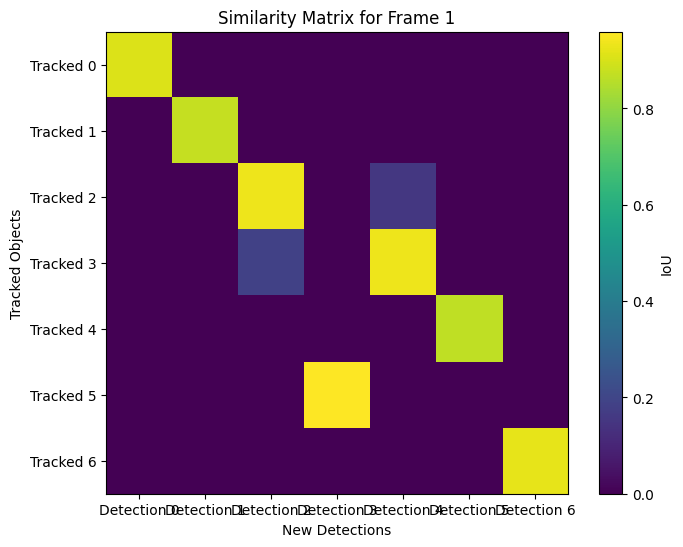

In [143]:
plot_similarity_matrix(similarity_matrix, 1)

In [ ]:
def store_bbx_id(detections_by_frame):
    
    if detections_by_frame is None or len(detections_by_frame) == 0:
        print("No detection in the frames")
        return None
    
    id_counter = 0
    frame = detections_by_frame[0]
    for i in range(len(frame)):
        frame[i][0] = id_counter
        id_counter += 1
    
    current_tracked = [frame]
    
    for i in range(1, len(detections_by_frame)):
        last_frame = current_tracked[i - 1]
        current_frame = detections_by_frame[i]
        similarity_matrix = create_similarity_matrix(last_frame, current_frame)
        mapping = get_mapping_boxes(similarity_matrix)
        
        for old_box, new_box, _ in mapping:
            current_frame[new_box][0] = last_frame[old_box][0]
        
        for box in current_frame:
            if box[0] == -1:
                box[0] = id_counter
                id_counter += 1
        
        
        current_tracked.append(current_frame)
    return current_tracked
            

In [145]:
current_tracked = store_bbx_id(detections_by_frame=detections_by_frame)

In [146]:
current_tracked

[[[0, 1700.0, 391.0, 156.0, 337.0, 0.91455],
  [1, 250.0, 456.0, 107.0, 248.0, 0.883148],
  [2, 1255.0, 539.0, 60.0, 118.0, 0.826354],
  [3, 1288.0, 459.0, 73.0, 199.0, 0.745969],
  [4, 120.0, 504.0, 93.0, 239.0, 0.740778],
  [5, 0.0, 243.0, 110.0, 666.0, 0.655897],
  [6, 1885.0, 369.0, 35.0, 213.0, 0.489681]],
 [[0, 1689.0, 390.0, 163.0, 338.0, 0.900352],
  [1, 262.0, 456.0, 96.0, 250.0, 0.875928],
  [2, 1257.0, 538.0, 59.0, 120.0, 0.823182],
  [5, 0.0, 247.0, 114.0, 662.0, 0.745286],
  [3, 1291.0, 461.0, 71.0, 197.0, 0.732246],
  [4, 119.0, 503.0, 83.0, 240.0, 0.72437],
  [6, 1884.0, 370.0, 35.0, 208.0, 0.512531]],
 [[0, 1686.0, 389.0, 163.0, 340.0, 0.908388],
  [1, 262.0, 456.0, 97.0, 251.0, 0.874236],
  [5, 0.0, 282.0, 119.0, 626.0, 0.811071],
  [2, 1260.0, 538.0, 56.0, 120.0, 0.781718],
  [4, 116.0, 503.0, 87.0, 240.0, 0.746885],
  [3, 1294.0, 460.0, 68.0, 198.0, 0.735964],
  [6, 1882.0, 368.0, 37.0, 206.0, 0.612416]],
 [[0, 1684.0, 390.0, 162.0, 341.0, 0.894863],
  [1, 262.0, 456

# 5 - Save video

In [ ]:
import os
import cv2

def display_and_save_tracking_from_images(image_folder, tracked_data, output_video_path):
    """
    Display image sequence with overlaid bounding boxes and save the tracking results as a video.
    
    Parameters:
        image_folder (str): Path to the folder containing image sequence.
        tracked_data (list): List of tracked bounding boxes for each frame.
        output_video_path (str): Path to save the output video.
    """
    # Get sorted list of image files
    image_files = sorted([os.path.join(image_folder, img) for img in os.listdir(image_folder) if img.endswith(('.jpg'))])
    if not image_files:
        print("Error: No images found in the folder.")
        return
    
    # Read the first image to get frame dimensions
    first_image = cv2.imread(image_files[0])
    frame_height, frame_width = first_image.shape[:2]
    fps = 10  # Assuming a default FPS for the output video

    # Define codec and create VideoWriter object
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'XVID' for .avi files
    out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))
    
    # Iterate through image files and overlay bounding boxes
    for frame_idx, image_path in enumerate(image_files):
        frame = cv2.imread(image_path)
        if frame_idx >= len(tracked_data):
            break
        
        # Get the bounding boxes for the current frame
        current_frame_boxes = tracked_data[frame_idx]
        
        # Draw bounding boxes and IDs on the frame
        for box in current_frame_boxes:
            track_id, x, y, w, h, conf = box
            # Draw rectangle
            cv2.rectangle(frame, (int(x), int(y)), (int(x + w), int(y + h)), (0, 255, 0), 2)
            # Add track ID label
            cv2.putText(frame, f"ID: {track_id}", (int(x), int(y - 10)), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)
        
        # Write frame to output video
        out.write(frame)
        
        # Display the frame
        cv2.imshow('Tracking', frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    
    # Release video resources
    out.release()
    cv2.destroyAllWindows()

# Example usage
image_folder = "CADL-Rundle-6\\img1"
output_video_path = "tracked_output_video.mp4"
display_and_save_tracking_from_images(image_folder, current_tracked, output_video_path)


## 6 - Save into file

In [ ]:
def save_tracking_results_txt_images(tracked_data, image_folder, output_dir):
    """
    Save tracking results to a text file in the required format for an image sequence.
    
    Parameters:
        tracked_data (list): List of tracked bounding boxes for each frame.
        image_folder (str): Path to the folder containing image sequence.
        output_dir (str): Directory to save the tracking results.
    """
    sequence_name = os.path.basename(os.path.normpath(image_folder))
    output_file = os.path.join(output_dir, f"{sequence_name}.txt")
    
    with open(output_file, 'w') as file:
        for frame_idx, frame_data in enumerate(tracked_data):
            for box in frame_data:
                track_id, x, y, w, h, conf = box
                file.write(f"{frame_idx + 1},{track_id},{x},{y},{w},{h},1,-1,-1,-1\n")
    
    print(f"Tracking results saved to {output_file}")


output_dir = "tracking_results"
os.makedirs(output_dir, exist_ok=True)
save_tracking_results_txt_images(current_tracked, image_folder, output_dir)

Tracking results saved to tracking_results\img1.txt
